In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
%matplotlib inline

import re
import random
from imblearn.over_sampling import RandomOverSampler
from scipy.sparse import hstack  # To combine sparse matrices
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier


import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df = pd.read_csv('./mhDataset.csv', index_col=0)

In [ ]:
df.dropna(inplace = True)

In [ ]:
import nltk
nltk.download('punkt_tab')
# Calculate the number of characters and sentences
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
df.rename(columns={'statement': 'original_statement'}, inplace=True)
df['statement']=df['original_statement'].str.lower()

In [ ]:
def remove_patterns(text):
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and other special characters
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# Apply the function to the 'statement' column
df['statement'] = df['statement'].apply(remove_patterns)

In [ ]:
# Apply word_tokenize to each element in the 'statement' column
df['tokens'] = df['statement'].apply(word_tokenize)

In [ ]:
lemmatizer=WordNetLemmatizer()

# Function to stem tokens and convert them to strings
def stem_tokens(tokens):
    return ' '.join(lemmatizer.lemmatize(token,pos="v") for token in tokens)

# Apply the function to the 'tokens' column
df['tokens_stemmed'] = df['tokens'].apply(stem_tokens)

In [ ]:
# Get the English stopword set
stop_words = set(stopwords.words('english'))

# Function to remove stopwords from a space-separated string
def remove_stopwords(text):
    return ' '.join(word for word in text.split() if word.lower() not in stop_words)

# Apply the function to the 'tokens_stemmed' column
df['tokens_stemmed'] = df['tokens_stemmed'].apply(remove_stopwords)

In [ ]:
from collections import Counter

class_counts = {
    'Depression':15404,
    'Normal': 16343,
    'Anxiety': 3841,
    'Bipolar': 2777,
    'Stress': 2587,
    'Personality disorder': 1077
}

total_samples = sum(class_counts.values())
num_classes = len(class_counts)

class_weights = {
    cls: total_samples / (num_classes * count)
    for cls, count in class_counts.items()
}

print(class_weights)

{'Depression': 0.4547411927637843, 'Normal': 0.42861367761936814, 'Anxiety': 1.8237004252364835, 'Bipolar': 2.5224462849597886, 'Stress': 2.707705192629816, 'Personality disorder': 6.504023522129372}


In [ ]:
X = df[['tokens_stemmed', 'num_of_characters', 'num_of_sentences']]
y = df['status']

In [ ]:
lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(y.values)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [ ]:
# 1. Initialize TF-IDF Vectorizer and fit/transform on the 'tokens' column
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)
X_train_tfidf = vectorizer.fit_transform(X_train['tokens_stemmed'])
X_test_tfidf = vectorizer.transform(X_test['tokens_stemmed'])

# 2. Extract numerical features
X_train_num = X_train[['num_of_characters', 'num_of_sentences']].values
X_test_num = X_test[['num_of_characters', 'num_of_sentences']].values

# 3. Combine TF-IDF features with numerical features
X_train_combined = hstack([X_train_tfidf, X_train_num])
X_test_combined = hstack([X_test_tfidf, X_test_num])

print('Number of feature words: ', len(vectorizer.get_feature_names_out()))

Number of feature words:  50000


In [ ]:
# Apply Random Over-Sampling on the vectorized data
ros = RandomOverSampler(random_state=101)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_combined, y_train)

In [ ]:
# Calculate sample weights based on the class_weights dictionary and the resampled training labels
sample_weights = np.array([class_weights[lbl_enc.inverse_transform([label])[0]] for label in y_train_resampled])

In [ ]:
# Define your models
models = {
    'Logistic Regression': LogisticRegression(random_state=101),

}



For Logistic Regression
Accuracy: 0.07304306447775398
                      precision    recall  f1-score   support

             Anxiety       0.00      0.00      0.00       790
             Bipolar       0.00      0.00      0.00       543
          Depression       0.96      0.13      0.22      3014
              Normal       0.00      0.00      0.00      3313
Personality disorder       0.03      0.99      0.06       232
              Stress       0.00      0.00      0.00       514

            accuracy                           0.07      8406
           macro avg       0.16      0.19      0.05      8406
        weighted avg       0.34      0.07      0.08      8406



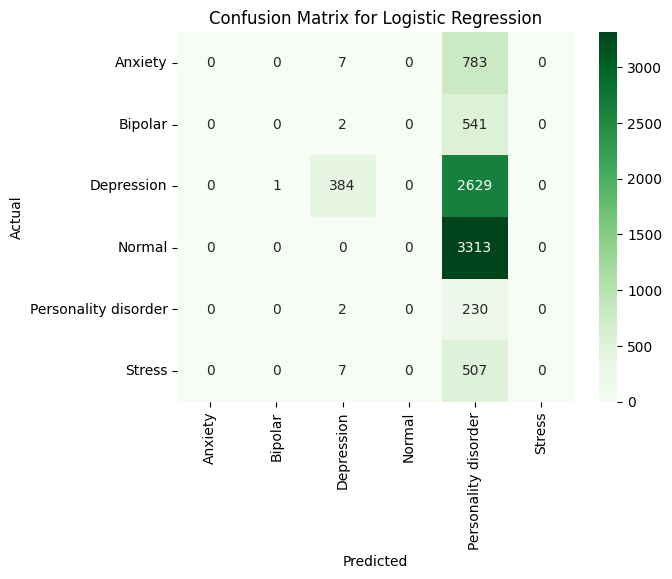

In [ ]:
# Initialize a list to store accuracy scores for each classifier
accuracy_scores = []

# Iterate over each classifier and its name in the models dictionary
for name, clf in models.items():
    # Fit the model with the calculated sample weights
    clf.fit(X_train_resampled, y_train_resampled, sample_weight=sample_weights)
    y_pred = clf.predict(X_test_combined)
    accuracy = accuracy_score(y_test, y_pred)

    print("\n")
    print("For", name)
    print("Accuracy:", accuracy)

    # Compute the confusion matrix for the predictions
    labels = lbl_enc.classes_
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred, target_names=labels))

    # Plot the confusion matrix using a heatmap
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

    # Append the accuracy score to the list
    accuracy_scores.append(accuracy)

# Task
Improve the logistic regression model for text classification.

## Feature engineering

### Subtask:
Experiment with different text vectorization techniques (e.g., different TF-IDF parameters, word embeddings like Word2Vec or GloVe) and consider adding other relevant features (e.g., readability scores).


**Reasoning**:
I will experiment with different `ngram_range` values and increase `max_features` in `TfidfVectorizer`, then combine the TF-IDF features with the numerical features.



Training with ngram_range: (1, 1), max_features: 50000
Accuracy: 0.4285034499167262
Training with ngram_range: (1, 1), max_features: 100000
Accuracy: 0.4869141089697835
Training with ngram_range: (1, 3), max_features: 50000
Accuracy: 0.6007613609326672
Training with ngram_range: (1, 3), max_features: 100000
Accuracy: 0.4873899595527004
Training with ngram_range: (2, 2), max_features: 50000
Accuracy: 0.4320723292886034
Training with ngram_range: (2, 2), max_features: 100000
Accuracy: 0.3749702593385677

Best parameters found:
ngram_range: (1, 3)
max_features: 50000
Best Accuracy: 0.6007613609326672

Classification Report for the best model:
                      precision    recall  f1-score   support

             Anxiety       0.62      0.80      0.70       790
             Bipolar       0.43      0.87      0.58       543
          Depression       0.98      0.42      0.59      3014
              Normal       0.93      0.63      0.75      3313
Personality disorder       0.28      0.78

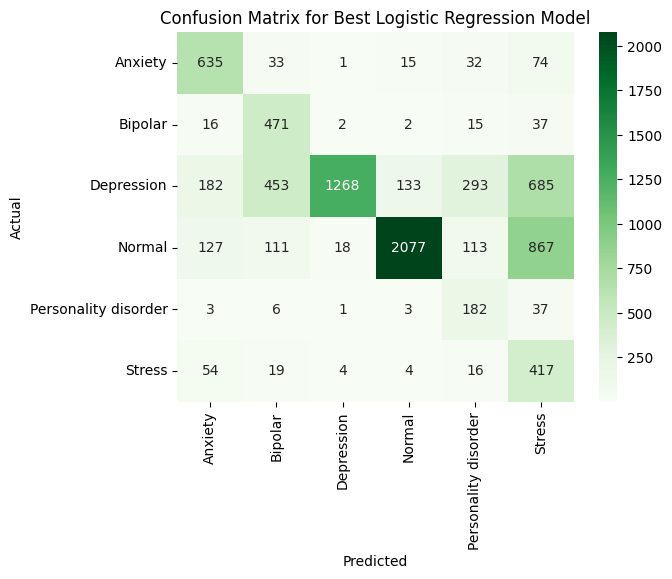

In [ ]:
# Experiment with different TF-IDF parameters
ngram_ranges = [(1, 1), (1, 3), (2, 2)]
max_features_list = [50000, 100000]

best_accuracy = 0
best_ngram_range = None
best_max_features = None
best_clf = None

for ngram_range in ngram_ranges:
    for max_features in max_features_list:
        print(f"Training with ngram_range: {ngram_range}, max_features: {max_features}")

        # 1. Initialize TF-IDF Vectorizer with new parameters
        vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
        X_train_tfidf = vectorizer.fit_transform(X_train['tokens_stemmed'])
        X_test_tfidf = vectorizer.transform(X_test['tokens_stemmed'])

        # 2. Extract numerical features
        X_train_num = X_train[['num_of_characters', 'num_of_sentences']].values
        X_test_num = X_test[['num_of_characters', 'num_of_sentences']].values

        # 3. Combine TF-IDF features with numerical features
        X_train_combined = hstack([X_train_tfidf, X_train_num])
        X_test_combined = hstack([X_test_tfidf, X_test_num])

        # Apply Random Over-Sampling on the vectorized data
        ros = RandomOverSampler(random_state=101)
        X_train_resampled, y_train_resampled = ros.fit_resample(X_train_combined, y_train)

        # Calculate sample weights based on the class_weights dictionary and the resampled training labels
        sample_weights = np.array([class_weights[lbl_enc.inverse_transform([label])[0]] for label in y_train_resampled])


        # Train Logistic Regression model
        clf = LogisticRegression(random_state=101, solver='liblinear') # Use liblinear solver for better performance with sparse data
        clf.fit(X_train_resampled, y_train_resampled, sample_weight=sample_weights)
        y_pred = clf.predict(X_test_combined)
        accuracy = accuracy_score(y_test, y_pred)

        print(f"Accuracy: {accuracy}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_ngram_range = ngram_range
            best_max_features = max_features
            best_clf = clf

print("\nBest parameters found:")
print(f"ngram_range: {best_ngram_range}")
print(f"max_features: {best_max_features}")
print(f"Best Accuracy: {best_accuracy}")

# Optionally, train the best model again and display metrics for the best one
if best_clf is not None:
    vectorizer = TfidfVectorizer(ngram_range=best_ngram_range, max_features=best_max_features)
    X_train_tfidf = vectorizer.fit_transform(X_train['tokens_stemmed'])
    X_test_tfidf = vectorizer.transform(X_test['tokens_stemmed'])
    X_train_num = X_train[['num_of_characters', 'num_of_sentences']].values
    X_test_num = X_test[['num_of_characters', 'num_of_sentences']].values
    X_train_combined = hstack([X_train_tfidf, X_train_num])
    X_test_combined = hstack([X_test_tfidf, X_test_num])

    ros = RandomOverSampler(random_state=101)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train_combined, y_train)
    sample_weights = np.array([class_weights[lbl_enc.inverse_transform([label])[0]] for label in y_train_resampled])

    best_clf.fit(X_train_resampled, y_train_resampled, sample_weight=sample_weights)
    y_pred = best_clf.predict(X_test_combined)

    print("\nClassification Report for the best model:")
    labels = lbl_enc.classes_
    print(classification_report(y_test, y_pred, target_names=labels))

    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for Best Logistic Regression Model')
    plt.show()

## Model selection and hyperparameter tuning

### Subtask:
Try different models suitable for text classification and tune their hyperparameters using techniques like GridSearchCV or RandomizedSearchCV.


**Reasoning**:
Define different models and their hyperparameter grids, then iterate through them using GridSearchCV.




Evaluating model: Logistic Regression
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for Logistic Regression: {'C': 10, 'penalty': 'l1'}
Best cross-validation F1-weighted score for Logistic Regression: grid_search.best_score_
Test set Accuracy for Logistic Regression: 0.8621222935998096
                      precision    recall  f1-score   support

             Anxiety       0.76      0.81      0.78       790
             Bipolar       0.80      0.84      0.82       543
          Depression       0.92      0.88      0.90      3014
              Normal       0.92      0.91      0.92      3313
Personality disorder       0.66      0.70      0.68       232
              Stress       0.54      0.63      0.58       514

            accuracy                           0.86      8406
           macro avg       0.77      0.79      0.78      8406
        weighted avg       0.87      0.86      0.86      8406



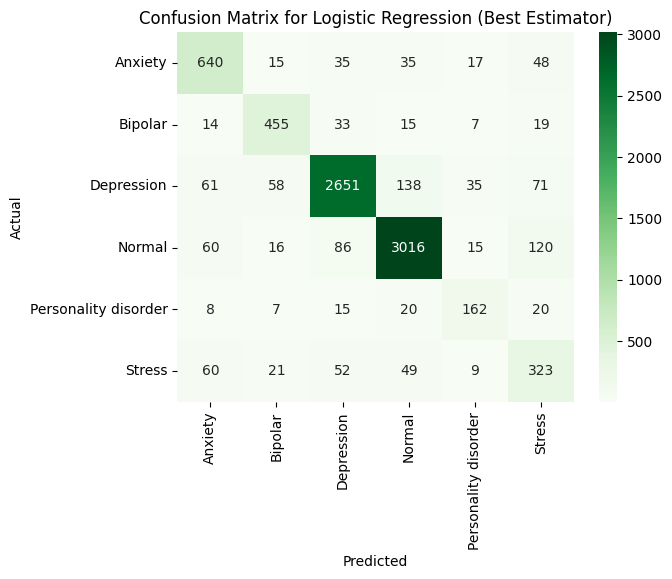


Summary of Best Logistic Regression Model and Score:
Logistic Regression: Best F1-weighted CV Score = 0.9584


In [ ]:
# Define the Logistic Regression model
models_to_evaluate = {
    'Logistic Regression': LogisticRegression(random_state=101, solver='liblinear', max_iter=1000) # Use liblinear solver for better performance with sparse data
}

# Define hyperparameter grid for Logistic Regression
param_grids_to_evaluate = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter
        'penalty': ['l1', 'l2']       # Type of regularization
    }
}

best_models = {}
best_scores = {}

# Iterate through the Logistic Regression model and perform GridSearchCV
for name, clf in models_to_evaluate.items():
    print(f"\nEvaluating model: {name}")
    param_grid = param_grids_to_evaluate[name]

    # Use GridSearchCV with appropriate scoring for imbalanced data (f1_weighted)
    # Setting refit=True to train the best estimator on the whole dataset
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=2)

    # Use the combined training data from the previous step (assuming best_ngram_range and best_max_features are available)
    # If not available, you might need to re-run the feature engineering step to get X_train_combined, X_test_combined, y_train_resampled, sample_weights
    # For now, let's assume X_train_combined, y_train_resampled, sample_weights from the best TF-IDF parameters are available.
    # You might need to adjust this part based on the actual state of your notebook.
    # Assuming X_train_resampled, y_train_resampled, sample_weights from the best TF-IDF run are in the environment.
    grid_search.fit(X_train_resampled, y_train_resampled, sample_weight=sample_weights)

    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best cross-validation F1-weighted score for {name}: grid_search.best_score_")

    # Store the best model and its score
    best_models[name] = grid_search.best_estimator_
    best_scores[name] = grid_search.best_score_

    # Evaluate the best model on the test set
    y_pred = best_models[name].predict(X_test_combined)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Test set Accuracy for {name}: {accuracy}")

    # Compute and print the classification report and confusion matrix
    labels = lbl_enc.classes_
    print(classification_report(y_test, y_pred, target_names=labels))

    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {name} (Best Estimator)')
    plt.show()

print("\nSummary of Best Logistic Regression Model and Score:")
for name, score in best_scores.items():
    print(f"{name}: Best F1-weighted CV Score = {score:.4f}")

In [ ]:
def predict_custom_input_with_probability(text, vectorizer, best_model, lbl_enc):
    # Apply the same preprocessing steps as the training data
    processed_text = remove_patterns(text.lower())
    tokens = word_tokenize(processed_text)
    stemmed_text = stem_tokens(tokens)
    cleaned_text = remove_stopwords(stemmed_text)

    # Calculate numerical features for the custom input
    num_of_characters = len(text)
    num_of_sentences = len(nltk.sent_tokenize(text))

    # Vectorize the processed text using the fitted TF-IDF vectorizer
    text_tfidf = vectorizer.transform([cleaned_text])

    # Combine TF-IDF features with numerical features
    custom_input_combined = hstack([text_tfidf, np.array([[num_of_characters, num_of_sentences]])])

    # Predict the class and get prediction probabilities using the best trained model
    prediction = best_model.predict(custom_input_combined)
    probabilities = best_model.predict_proba(custom_input_combined)

    # Decode the predicted class label
    predicted_label = lbl_enc.inverse_transform(prediction)[0]

    # Get the probability of the predicted class
    predicted_class_index = prediction[0]
    certainty = probabilities[0][predicted_class_index]

    return predicted_label, certainty

# Now, please provide your input text:
# custom_text = "Replace this with your text"
# predicted_class, certainty = predict_custom_input_with_probability(custom_text, vectorizer, best_models['Logistic Regression'], lbl_enc)
# print(f"The predicted class for the input text is: {predicted_class} with a certainty of {certainty:.2f}")

# Example usage with previous texts:
custom_text_1 = "I know it’s irrational, but it still feels so real."
predicted_class_1, certainty_1 = predict_custom_input_with_probability(custom_text_1, vectorizer, best_models['Logistic Regression'], lbl_enc)
print(f"The predicted class for the input text is: {predicted_class_1} with a certainty of {certainty_1:.2f}")

custom_text_2 = "I am happy today."
predicted_class_2, certainty_2 = predict_custom_input_with_probability(custom_text_2, vectorizer, best_models['Logistic Regression'], lbl_enc)
print(f"The predicted class for the input text is: {predicted_class_2} with a certainty of {certainty_2:.2f}")

custom_text_3 = "I have an important presentation tomorrow and I am feeling very nervous."
predicted_class_3, certainty_3 = predict_custom_input_with_probability(custom_text_3, vectorizer, best_models['Logistic Regression'], lbl_enc)
print(f"The predicted class for the input text is: {predicted_class_3} with a certainty of {certainty_3:.2f}")

The predicted class for the input text is: Normal with a certainty of 0.66
The predicted class for the input text is: Normal with a certainty of 0.56
The predicted class for the input text is: Anxiety with a certainty of 0.96


In [ ]:
import pickle

# Assuming 'best_models' dictionary contains the best trained Logistic Regression model
best_logistic_model = best_models['Logistic Regression']

# Define the filename for the pickled model
model_filename = 'best_logistic_regression_model.pkl'

# Save the model to a file using pickle
with open(model_filename, 'wb') as file:
    pickle.dump(best_logistic_model, file)

print(f"Best Logistic Regression model saved to '{model_filename}'")

Best Logistic Regression model saved to 'best_logistic_regression_model.pkl'


In [ ]:
import pickle

# Define filenames for the pickled vectorizer and label encoder
vectorizer_filename = 'tfidf_vectorizer.pkl'
label_encoder_filename = 'label_encoder.pkl'

# Save the fitted TF-IDF vectorizer
with open(vectorizer_filename, 'wb') as file:
    pickle.dump(vectorizer, file)

print(f"TF-IDF vectorizer saved to '{vectorizer_filename}'")

# Save the fitted Label Encoder
with open(label_encoder_filename, 'wb') as file:
    pickle.dump(lbl_enc, file)

print(f"Label encoder saved to '{label_encoder_filename}'")

TF-IDF vectorizer saved to 'tfidf_vectorizer.pkl'
Label encoder saved to 'label_encoder.pkl'
